In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
from tapm import bigmodel_STI
import icomo
import numpy as np
import copy
from matplotlib.colors import LogNorm
from tapm import utils

ERROR:tapm.HIVandSTI.model_HIVandSTI:y_0 does not add up to 1 for HIV.
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


# TEST FOR MODEL : AND ITS WORKING

In [2]:

def compute_sti_infections(
    Hs, Ps, lambda_P_values, args, y0_in, filename=None
):
    """
    Compute STI infections for given H, P, and lambda_P values and store the results for different H values.

    Parameters:
    Hs (list): List of H values.
    Ps (list): List of P values.
    lambda_P_values (list): List of lambda_P values.
    y0 (dict): Initial state of the system.
    args (dict): Arguments for the model.
    integrator (function): Function to integrate the model.
    model_STI (module): Module containing STI model functions.
    filename (str): Name of the file to save the results.

    Returns:
    dict: Results for different H values.
    """
    # Dictionary to store results for different H values
    results = {}

    # Loop over each value of H
    for H in Hs:
        args_mod = args.copy()
        args_mod["H"] = H
        # Determine the size of the result matrices
        res_size = [len(lambda_P_values), len(Ps)]

        # Initialize result matrices
        res_Ia = np.zeros(res_size)  # Asymptomatic STI infections
        res_Is = np.zeros(res_size)  # Symptomatic STI infections
        res_T = np.zeros(res_size)  # Treated STI infections
        res_S = np.zeros(res_size)
        res_prevalance = np.zeros(res_size)  # Total infections
        check = np.zeros(res_size)  # Convergence check
        check_1 = np.zeros(res_size)

        # Loop over each lambda_P value
        for i, lambda_P in enumerate(lambda_P_values):
            for j, P in enumerate(Ps):
                args_mod["P"] = P
                args_mod["lambda_P"] = lambda_P

                #print(f"Running for H={H}, P={P}, lambda_P={lambda_P}, y0={y0_in}")
                
                output = icomo.diffeqsolve(
                    args = args_mod,
                    ODE = bigmodel_STI.main_model,
                    y0 = y0_in,
                    ts_out = np.linspace(0, 365*80, 365*80+1),
                    max_steps=365*80+1)
                
                # Get the final state of the system
                y1 = {key: value[-1] for key, value in output.ys.items()}
                y2 = {key: value[-5] for key, value in output.ys.items()}
                #check convergence by comparing last value to fifth last value
                #for key in y1:
                #    if not np.allclose(y1[key], y2[key], rtol=0, atol=1e-8):
                #        print(f"Convergence failed: P: {P}, H: {H}, {key}: (diff = {abs(y1[key] - y2[key])})")
                
                # Record the final susceptible individuals
                res_S[i, j] = jnp.sum(y1["S_STI"])

                # Record the final asymptomatic STI infections
                res_Ia[i, j] = jnp.sum(y1["Ia_STI"])

                # Record the final symptomatic STI infections
                res_Is[i, j] = jnp.sum(y1["Is_STI"])

                # Record the final treated STI infections
                res_T[i, j] = jnp.sum(y1["T_STI"])


                # Calculate total new infections
                res_prevalance[i, j] = res_Ia[i, j] + res_Is[i, j] 


                check_1[i, j] = res_S[i, j] + res_Ia[i, j] + res_Is[i, j] + res_T[i, j] 
                # if abs(check_1[i, j] - 1) > 1e-8:
                #     print(f"Population did not stay constant (H = {H}, P = {P}, sum = {check_1[i, j]})")


        # Store the results for the current H value
        results[H] = {
            "res_S": res_S,
            "res_Ia": res_Ia,
            "res_Is": res_Is,
            "res_T": res_T,
            "res_infections": res_prevalance,
            "check": check,
            "check_1": check_1,
        }


    # Save the results to a file
    
    
    #if filename:
    #    utils.save_results(results, filename)

    return results



# Define the parameters
Hs = np.linspace(0.0, 0.2, 101)
Ps = np.linspace(0, 1, 201)
lambda_P_values = np.array([1.0, 2.0, 4.0]) / 365.0
args = bigmodel_STI.args
result_prevalance = compute_sti_infections(Hs, Ps, lambda_P_values, args, bigmodel_STI.y0, filename=None)
utils.save_results(result_prevalance, filename="result_for_fig_1_bigSTImodel")

INFO:tapm.HIVandSTI.bigmodel_STI:Using exponential function to calculate m
INFO:tapm.HIVandSTI.bigmodel_STI:Parameters: m_min = 0.0, m_max = 1
INFO:tapm.utils:Results saved to ../results/result_for_fig_1_bigSTImodel.npy


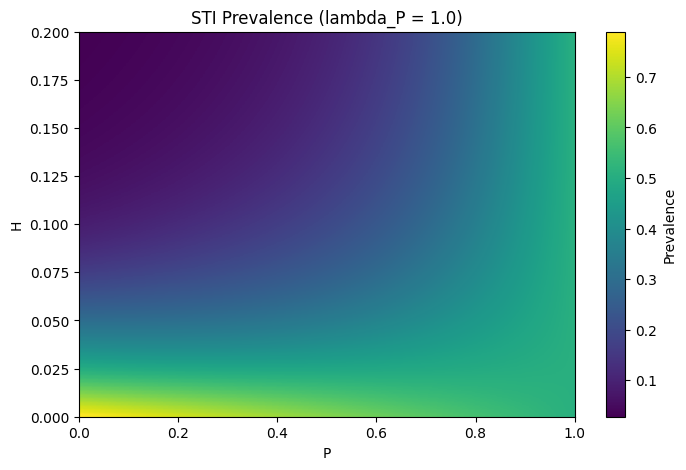

In [3]:

# Select the index of lambda_P_values
lambda_P_idx = 0

# Create a prevalence matrix for heatmap: rows=Hs, columns=Ps
prevalence_matrix = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    # Each H value is used as a key, we take only the desired lambda_P index row
    prevalence_matrix[i, :] = result_prevalance[H]["res_infections"][lambda_P_idx,:]

plt.figure(figsize=(8, 5))
im = plt.imshow(
    prevalence_matrix, 
    aspect='auto',
    extent=[Ps[0], Ps[-1], Hs[0], Hs[-1]],    # Y axis = H from low to high
    origin='lower',                           # H increases upward (lower = H[0])
    cmap='viridis',
    #vmax = 0.7
    #norm=LogNorm(vmin=prevalence_matrix.min(), vmax=prevalence_matrix.max())
)
plt.colorbar(im, label='Prevalence')
plt.xlabel("P")
plt.ylabel("H")
plt.title(f"STI Prevalence (lambda_P = {lambda_P_values[lambda_P_idx]*365})")
plt.show()

# Final Figure 1

## Data generation

In [2]:
def compute_sti_infections_grid(
    Hs, Ps, lambda_P_values, beta_STI_values, args, y0_in, filename=None
):
    """
    Computes and saves results as: results[(beta_STI, lambda_P)] = (len(Hs), len(Ps)) array of res_infections
    """
    import numpy as np

    results = {}
    for beta_STI in beta_STI_values:
        args_base = args.copy()
        args_base["beta_STI"] = beta_STI
        for i_lambda, lambda_P in enumerate(lambda_P_values):
            res_prevalence = np.zeros((len(Hs), len(Ps)))
            for i_H, H in enumerate(Hs):
                args_mod = args_base.copy()
                args_mod["H"] = H
                args_mod["lambda_P"] = lambda_P
                for j_P, P in enumerate(Ps):
                    args_mod["P"] = P
                    
                    output = icomo.diffeqsolve(
                        args=args_mod,
                        ODE=bigmodel_STI.main_model,
                        y0=y0_in,
                        ts_out=np.linspace(0, 365*80, 365*80+1),
                        max_steps=365*80+1
                    )
                    y1 = {key: value[-1] for key, value in output.ys.items()}
                    Ia = np.sum(y1["Ia_STI"])
                    Is = np.sum(y1["Is_STI"])
                    res_prevalence[i_H, j_P] = Ia + Is
            results[(beta_STI, lambda_P)] = res_prevalence

    # Optionally save
    if filename:
        from tapm import utils
        utils.save_results(results, filename)

    return results

In [3]:
# Define the parameter sets as before
Hs = np.linspace(0.0, 0.2, 101)
Ps = np.linspace(0, 1, 201)
lambda_P_values = np.array([1.0, 2.0, 4.0]) / 365.0
beta_STI_values = [0.0016 * 5.0, 0.0016 * 7.0]

args = bigmodel_STI.args
y0 = bigmodel_STI.y0

results = compute_sti_infections_grid(Hs, Ps, lambda_P_values, beta_STI_values, args, y0, filename="result_for_fig_1_bigSTImodel")

INFO:tapm.HIVandSTI.bigmodel_STI:Using exponential function to calculate m
INFO:tapm.HIVandSTI.bigmodel_STI:Parameters: m_min = 0.0, m_max = 1
INFO:tapm.utils:Results saved to ../results/result_for_fig_1_bigSTImodel.npy


## Figure 1

C:\Users\PMallick\AppData\Local\Temp\ipykernel_10168\761060588.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, 10, 20], fontsize=8)
C:\Users\PMallick\AppData\Local\Temp\ipykernel_10168\761060588.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0, 50, 100], fontsize=8)
C:\Users\PMallick\AppData\Local\Temp\ipykernel_10168\761060588.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, 10, 20], fontsize=8)
C:\Users\PMallick\AppData\Local\Temp\ipykernel_10168\761060588.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0, 50, 100], fontsize=8)
C:\Users\PMallick\AppD

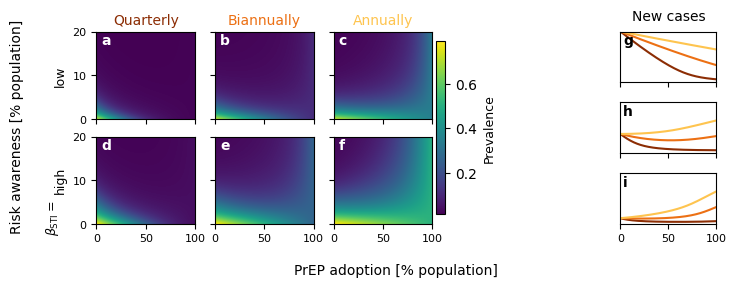

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Your definitions
beta_STI_values = [0.0016 * 5.0, 0.0016 * 7.0]
lambda_P_values = [4/365.0, 2/365.0, 1/365.0]
lambda_P_labels = ["Quarterly", "Biannually", "Annually"]
colors_R0 = ["#8c2d04", "#ec7014", "#fec44f"]
Hs = np.linspace(0.0, 0.2, 101)
Ps = np.linspace(0, 1, 201)

# Find global min/max for color scaling
allvals = np.concatenate([results[(beta, lam)].flatten() for beta in beta_STI_values for lam in lambda_P_values])
global_vmin = np.nanmin(allvals)
global_vmax = np.nanmax(allvals)

fig = plt.figure(figsize=(8, 2.5))
outer_grid = fig.add_gridspec(1, 2, width_ratios=[2.5, 0.6], wspace=0.5)
left_grid = outer_grid[0].subgridspec(2, 3, wspace=0.2, hspace=0.2)
axes = [[fig.add_subplot(left_grid[i, j]) for j in range(3)] for i in range(2)]

for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        arr = np.clip(results[(beta_STI, lambda_P)], 0, None)
        cax = ax.imshow(
            arr, origin="lower",
            vmin=global_vmin, vmax=global_vmax,
            interpolation="bicubic",
            extent=[Ps[0]*100, Ps[-1]*100, Hs[0]*100, Hs[-1]*100],
            aspect='auto'
        )
        if row_idx == 0:
            ax.set_title(label, fontsize=10, pad=5, color=colors_R0[col_idx])
        if col_idx == 0:
            ax.set_ylabel(['low','high'][row_idx], fontsize=9)
        if row_idx == 1:
            ax.set_xticklabels([0, 50, 100], fontsize=8)
        else:
            ax.set_xticklabels([])
        ax.set_xticks([0, 50, 100])
        if col_idx == 0:
            ax.set_yticklabels([0, 10, 20], fontsize=8)
        else:
            ax.set_yticklabels([])
        ax.set_yticks([0, 10, 20])

# Add letters a-f
letters = "abcdef"
for idx, ax in enumerate([a for row in axes for a in row]):
    ax.text(0.05, 0.98, letters[idx], transform=ax.transAxes,
            fontsize=10, fontweight="bold", va="top", ha="left", color="white")

# Color bar
cbar = fig.colorbar(
    cax,
    ax=[a for row in axes for a in row],
    shrink=0.9, pad=0.01,
    format="%.1f"
)
cbar.ax.set_ylabel("Prevalence", fontsize=9)

# Right panel (g-i): lineplots at fixed H, use high beta_STI
right_grid = outer_grid[1].subgridspec(3, 1, hspace=0.4)
axs = [fig.add_subplot(right_grid[i]) for i in range(3)]
fixed_H_indexes = [0, int(len(Hs)*0.25), int(len(Hs)*0.5)]
for ax, H_index in zip(axs, fixed_H_indexes):
    for idx, lambda_P in enumerate(lambda_P_values):
        arr = results[(beta_STI_values[1], lambda_P)]   # row_idx=1 = high
        Y = arr[H_index, :]
        ax.plot(Ps*100, Y, color=colors_R0[idx], linewidth=1.5)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, global_vmax)
    ax.set_xticks([0, 50, 100])
    if ax != axs[-1]:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([0, 50, 100], fontsize=8)
    ax.set_yticks([])
    ax.set_yticklabels([])

axs[0].set_title("New cases", fontsize=10, pad=8)

letters2 = ["g", "h", "i"]
for idx, ax in enumerate(axs):
    ax.text(0.03, 0.96, letters2[idx], transform=ax.transAxes,
            fontsize=10, fontweight="bold", va="top", ha="left")

fig.text(0.5, -0.09, "PrEP adoption [% population]", ha="center", fontsize=10)
fig.text(0.017, 0.5, "Risk awareness [% population]", va="center", rotation="vertical", fontsize=10)
fig.text(0.06, 0.135, r"$\beta_\mathrm{STI}=$", va="center", rotation="vertical", fontsize=9)

# plt.tight_layout()
plt.show()